# AWS-ASDI Auto-Regressive Model Example

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import sys

In [2]:
import ray
from modin import pandas as pd
from nums import numpy as nps
from nums.core import settings
from nums.experimental import nums_modin
import boto3
from tqdm import tqdm

In [5]:
# Cluster settings
os.environ["RAY_IGNORE_UNHANDLED_ERRORS"] = "1"
# ray.init(ignore_reinit_error=True, address="auto") # On cluster
ray.init() # On local machine
if len(ray.nodes()) > 1:
    settings.cluster_shape = (len(ray.nodes()) - 1, 1)
settings.cluster_shape

2021-09-24 13:21:18,208	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265


(1, 1)

# Global Variables

In [15]:
# Global variables
elements = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]
all_years = list(range(1800, 2022))
local = True

In [ ]:
if local:
    stations = pd.read_fwf("../ghcnd/ghcnd-stations.txt", widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None)
else:
    stations = pd.read_fwf("s3://noaa-ghcn-pds/ghcnd-stations.txt", widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None)
stations.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN FLAG", "HCN/CRN FLAG", "WMO ID"]
stations

# Utility Functions

Load inventory table of year ranges for which a feature is available from a particular station.

In [6]:
inventory = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-inventory.txt', widths=[12, 9, 10, 4, 5, 5], header=None, 
                        names=["ID", "LATITUDE", "LONGITUDE", "ELEMENT", "FIRSTYEAR", "LASTYEAR"])
inventory.head()

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949


In [7]:
stations = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-stations.txt', widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None, 
                       names=["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN FLAG", "HCN/CRN FLAG", "WMO ID"])
stations.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,NaN,DUBAI INTL,NaN,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,NaN,ABU DHABI INTL,NaN,NaN,41217.0


We define a function that loads the dataframe for a specific year from .csv data, then use it to load dataframes from 1800-2021, caching them in a dictionary.

In [8]:
# Memoize dictionary of yearly dfs
def data_loader(year, local=False):
    assert year in all_years
    if local:
        df = pd.read_csv(f"../ghcnd/csv/{year}.csv", header=None, names=[
            "ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"
        ])
    else:
        df = pd.read_csv(f"s3://noaa-ghcn-pds/csv/{year}.csv", header=None, names=[
            "ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"
        ])
    df.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
    df["YEAR/MONTH/DAY"] = pd.to_datetime(df["YEAR/MONTH/DAY"], format="%Y%m%d")
    return df

year_dfs = {}
for year in all_years:
    year_dfs[year] = data_loader(year, local)

For each station, we create a time series dataframe. This involves selecting rows from all year_dfs with a matching station ID and element and appending them, with the date as the index.

In [9]:
def time_series(years_range, station_id, elements, local=False, df=None):
    assert isinstance(elements, list)
    df_elements = pd.DataFrame(columns=["DATA VALUE"])
    for year in tqdm(years_range):
        df = data_loader(year, local)
        df = df.loc[(df["ID"] == station_id) & (df["ELEMENT"].isin(elements))]
        
        if df_elements.empty:
            df_elements = df
        else:
            df_elements = df_elements.append(df)
        
    df_result = pd.pivot_table(df_elements, values=["DATA VALUE"], index=["YEAR/MONTH/DAY"], columns=["ELEMENT"])
    df_result = df_result.sort_index()
    return df_result
    
# Save created time series? Using s3?

Return maximal time series from available year ranges for features from a station.

In [ ]:
def max_time_series(station_id, elements, local=local):
    start, end = 0, np.inf
    for el in elements:
        start = max(start, inventory[(inventory["ID"]==station_id) & (inventory["ELEMENT"]==el)]["FIRSTYEAR"])
        end = min(end, inventory[(inventory["ID"]==station_id) & (inventory["ELEMENT"]==el)]["LASTYEAR"])
    if start <= end:
        return time_series(range(start, end + 1), station_id, elements, local=local)

Standard RMSE to be used during testing.

In [11]:
def rmse(y, pred):
    if isinstance(y, np.ndarray):
        return np.sqrt(np.mean((pred - y) ** 2))
    else:
        return nps.sqrt(nps.mean((pred - y) ** 2))

# Univariate AR Using Yule-Walker Equations

# Multivariate AR

We write function that generates the multivariate design matrix. 

In [29]:
def multivar_ar(years_range, station_id, predictors, response, p=10, local=False, df=None):
    assert isinstance(predictors, list)
    elements = predictors
    if response not in predictors:
        elements.append(response)
    if df is None:
        df = time_series(years_range, station_id, elements, local=local)
    else:
        df = df[elements]
    # num_pred = len(predictors)
    df_len = df.shape[0]
    
    # NumPy version
#     pred_series = df[predictors].to_numpy().flatten()
#     pred_ind = np.arange(num_pred * p).reshape(1, -1) + num_pred * np.arange(df_len - p).reshape(-1, 1)
#     pred_mat = pred_series[pred_ind]
    
#     resp_vec = df[response].to_numpy()[p:].reshape(-1, 1)
#     combined = np.hstack((pred_mat, resp_vec))
#     cleaned2 = combined[~np.isnan(combined).any(axis=1)]

    # NumPy version 2
#     pred_series = np.array(df[predictors].to_numpy())
#     pred_mat = np.hstack([pred_series[i : df_len - p + i] for i in np.arange(p)])
    
#     resp_vec = np.array(df[response].to_numpy())[p:].reshape(-1, 1)
#     combined = np.concatenate((pred_mat, resp_vec), axis=1)
#     cleaned2 = combined[~np.any(np.isnan(combined), axis=1)]
    
    # NumS + Modin version
    pred_df = pd.concat([df[predictors].iloc[i : df_len - p + i]
                         .reset_index(drop=True) for i in np.arange(p)], axis=1)
    resp_df = df[response].iloc[p:].reset_index(drop=True)
    
    # impute avg temp on day across all years instead of drop? then add check for NaN
    # OR impute using sklearn preprocessor (plan B)
    combined_df = pd.concat((pred_df, resp_df), axis=1).dropna() 
    
    # Add constant intercept term
    combined_df["INTERCEPT"] = 1  # REMOVE, sklearn adds it already
    
    # check if from_modin returns single partition
    # new argument to enforce single partition NumS array
    combined = nums_modin.from_modin(combined_df) 
    return combined[:, :-1], combined[:, -1].T

Create our linear regression model.

In [30]:
from nums.models.glms import LinearRegression

# ElasticNet, GradientBoostedTreeReg, RandomForestTreeReg, MLPReg, SVR x p ranges per station
# Use MSE to score random validation set (0.2)
# Train on training + validation set, test with best model (0.2)
model = LinearRegression()
p = 20
predictors = ["TMAX", "TMIN", "PRCP", "SNOW"]
response = "TMAX"
X, y = multivar_ar(range(2000, 2002), "CA001011500", predictors, response, p=p, local=local, df=df_test)
print(X.shape, X.block_shape)
print(y.shape, y.block_shape)
model.fit(X.astype(np.double), y.astype(np.double))
print(model._beta.get().shape)

(970, 80) (970, 80)
(970,) (970,)
(80,)


Test our model on actual temperature data from a different time range. The RMSE is in units of a tenth of a degree Celcius.

In [31]:
X_test, y_test = multivar_ar(range(2002, 2003), "CA001011500", predictors, response, p=p, local=local, df=df_test)
XX_test = X_test.astype(np.double)
yy_test = y_test.astype(np.double)
pred = model.predict(XX_test)
print(rmse(yy_test, pred).get())

22.32199352710446


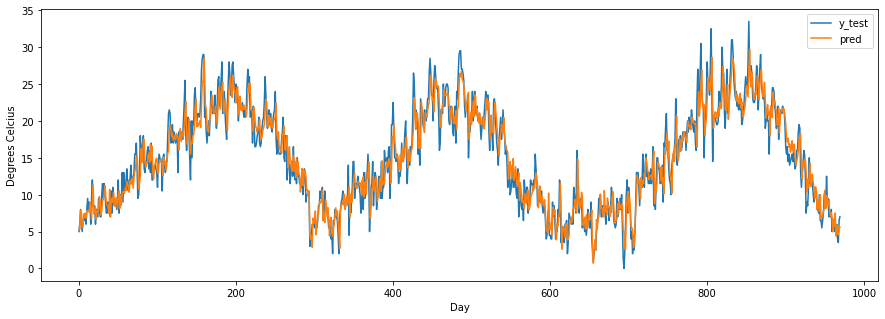

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(yy_test.size), yy_test.get() / 10, label="y_test")
plt.plot(np.arange(pred.size), pred.get() / 10, label="pred")
plt.xlabel("Day")
plt.ylabel("Degrees Celcius")
plt.legend()
plt.show()

Visualize the weight parameters of our model.

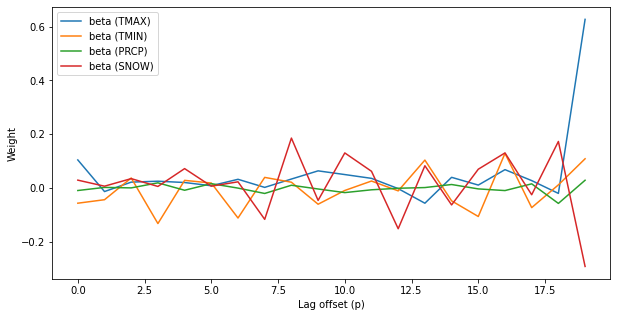

In [35]:
plt.figure(figsize=(10, 5))
for i, pr in enumerate(predictors):
    plt.plot(np.arange(model._beta.size / len(predictors)), model._beta.get()[i::len(predictors)], label=f"beta ({pr})")
plt.xlabel("Lag offset (p)")
plt.ylabel("Weight")
plt.legend()
plt.show()

In [ ]:
predictors = ["TMAX", "TMIN", "PRCP", "SNOW"]
filtered_inv = inventory[inventory["ELEMENT"].isin(predictors)]
agg_dict = {
    "FIRSTYEAR": np.max;
    "LASTYEAR": np.min;
}
station_ranges = filtered_inv.groupby("ID").filter(lambda g: len(g) != len(predictors)).agg(agg_dict)
station_ranges.head()

In [ ]:
from nums.sklearn import *

for station_range in station_ranges.itertuples():
    

# for station_id in stations["ID"]:
#     check inventory, get range for station
#     split range to train, validation test sets
#     do hyperparameter search on lag p with (cross) validation
#     train on sklearn actor model
#     sklearn pipelines?